In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim 

C:\Users\mjseo\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
movie = pd.read_csv('../data/ratings.csv', low_memory=False)
movie.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [4]:
# 영화를 시간순으로 정렬

movie = movie.sort_values(by='timestamp', ascending=True).reset_index(drop=True)
movie.head()

,userId,movieId,rating,timestamp
0,383,21,3.0,789652009
1,383,47,5.0,789652009
2,383,1079,3.0,789652009
3,409,21,5.0,828212412
4,409,25,4.0,828212412


In [5]:
# 영화의 Metadata를 불러와서 movieID에 맞는 TITLE을 구해줍니다. 
meta = pd.read_csv('../data/movies_metadata.csv', low_memory=False)
meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [6]:
meta.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [7]:
meta = meta.rename(columns={'id':'movieId'})     # 컬럼명 변경
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], how='left', on='movieId')  # 조인

In [8]:
movie = movie[movie['original_title'].notnull()].reset_index(drop=True)

In [15]:
movie.head()

# meta data에 original_title 결측치가 많아서 결과 값은 잘 안나온다 함 ..

,userId,movieId,rating,timestamp,original_title
0,383,21,3.0,789652009,The Endless Summer
1,409,21,5.0,828212412,The Endless Summer
2,409,25,4.0,828212412,Jarhead
3,409,30,5.0,828212412,彼女の想いで
4,409,35,4.0,828212412,The Simpsons Movie


In [9]:
agg = movie.groupby(['userId'])['original_title'].agg({'unique'})
agg.head()

,unique
userId,
1,"[Jay and Silent Bob Strike Back, Vivement dima..."
2,"[Terminator 3: Rise of the Machines, The Conve..."
3,"[300, The Killing, Shortbus, Finding Neverland..."
4,"[David, The Wedding Planner, Casablanca, Sleep..."
5,"[Gleaming the Cube, Cool Hand Luke, Hidalgo, U..."


In [10]:
movie['original_title'].unique()

array(['The Endless Summer', 'Jarhead', '彼女の想いで', ...,
       'The Lonedale Operator', 'Violeta se fue a los cielos',
       'To Kill a Priest'], dtype=object)

In [11]:
# int형식은 Word2vec에서 학습이 안되어서 String으로 변경해줍니다. 

# 영화 제목 하나하나를 단어로 보고 word2vec 적용
sentence = []
for user_sentence in agg['unique'].values:
    sentence.append(list(map(str, user_sentence)))

In [18]:
# Word2vec의 학습을 진행해줍니다. 
from gensim.models import Word2Vec
embedding_model = Word2Vec(sentence, vector_size=20, window = 5, 
                           min_count=1, workers=4, epochs=200, sg=1) # 1 : skip-gram; 0 : CBOW.

In [19]:
embedding_model.wv.most_similar(positive=['Spider-Man 2'], topn=10)

[('Snow Cake', 0.8632984757423401),
 ("L'Aile ou la Cuisse", 0.8203212022781372),
 ('Harry Potter and the Prisoner of Azkaban', 0.7454668879508972),
 ('Star Trek: Nemesis', 0.731774628162384),
 ('Blow', 0.7273211479187012),
 ('Rumor Has It...', 0.7206325531005859),
 ('Die Ehe der Maria Braun', 0.7145217657089233),
 ('Conquest of the Planet of the Apes', 0.7124094367027283),
 ('Vicky Cristina Barcelona', 0.7123990654945374),
 ('Sunrise: A Song of Two Humans', 0.7123129367828369)]

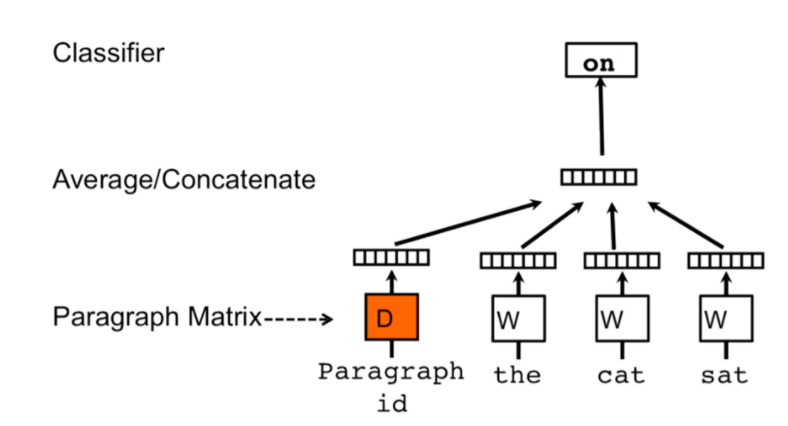

In [20]:
from gensim.models import doc2vec

In [21]:
meta = pd.read_csv('../data/movies_metadata.csv', low_memory=False)
meta = meta[meta['original_title'].notnull()].reset_index(drop=True)
meta = meta[meta['overview'].notnull()].reset_index(drop=True)

In [22]:
from nltk.corpus import stopwords 
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
import re 
stop_words = set(stopwords.words('english')) 

overview = []
for words in tqdm(meta['overview']):
    word_tokens = word_tokenize(words)
    sentence = re.sub('[^A-Za-z0-9]+', ' ', str(word_tokens))
    sentence = sentence.strip()
    
    sentence_tokens = word_tokenize(sentence)
    result = ''
    for token in sentence_tokens: 
        if token not in stop_words:
            result += ' ' + token 
    result = result.strip().lower()
    overview.append(result)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\mjseo/nltk_data'
    - 'C:\\Users\\mjseo\\anaconda3\\nltk_data'
    - 'C:\\Users\\mjseo\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\mjseo\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\mjseo\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
meta['pre_overview'] = overview

In [ ]:
doc_vectorizer = doc2vec.Doc2Vec(
    dm=0,            # PV-DBOW / default 1
    dbow_words=1,    # w2v simultaneous with DBOW d2v / default 0
    window=10,        # distance between the predicted word and context words
    size=100,        # vector size
    alpha=0.025,     # learning-rate
    seed=1234,
    min_count=5,    # ignore with freq lower
    min_alpha=0.025, # min learning-rate
    workers=4,   # multi cpu
    hs = 1,          # hierar chical softmax / default 0
    negative = 10   # negative sampling / default 5
)

In [ ]:
from collections import namedtuple

agg = meta[['id', 'original_title', 'pre_overview']]
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument((c), [d]) for d, c in agg[['original_title', 'pre_overview']].values]

In [ ]:
doc_vectorizer.build_vocab(tagged_train_docs)
print(str(doc_vectorizer))

In [ ]:
# 벡터 문서 학습
from time import time

start = time()

for epoch in tqdm(range(5)):
    doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.iter)
    doc_vectorizer.alpha -= 0.002 # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha # fix the learning rate, no decay

#doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.iter)
end = time()
print("During Time: {}".format(end-start))

In [ ]:
doc_vectorizer.docvecs.most_similar('Toy Story', topn=20)

In [ ]:
doc_vectorizer.docvecs.most_similar('Harry Potter and the Deathly Hallows: Part 1', topn=20)